# 1. 인공지능과 가위바위보 하기

## 미니 프로젝트 : 가위바위보 분류기를 만들자

### 1. 데이터 불러오기 + Resize 하기

In [2]:
# 라이브러리 불러오기
from PIL import Image
import glob
import matplotlib.pyplot as plt
import os

In [3]:
# 이미지 resize
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "rock_scissor_paper/scissor"
resize_images(image_dir_path)

# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "rock_scissor_paper/rock"
resize_images(image_dir_path)

# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "rock_scissor_paper/paper"
resize_images(image_dir_path)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


In [4]:
import numpy as np

# 라벨링
def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("데이터의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

데이터의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


라벨:  0


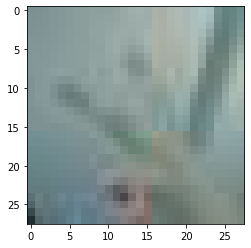

In [5]:
# 참고. 이미지 불러와서 확인
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

### 딥러닝 네트워크 설계하기

In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
# [[YOUR CODE]]
# tf.keras의 Sequential API를 이용하여 LeNet이라는 딥러닝 네트워크를 설계
n_channel_1=32
n_channel_2=64
n_dense=64

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

# 만든 딥러닝 네트워크 모델 확인
model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (No

### 딥러닝 네트워크 학습시키기

In [19]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.compile()과 model.fit()을 사용해 봅시다.
# [[YOUR CODE]]
x_train_reshaped=x_train_norm.reshape(-1, 28, 28, 3)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산됩니다.

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

n_train_epoch = 15

model.fit(x_train_reshaped, y_train, epochs=n_train_epoch)  # epochs=n # n번 반복해서 학습시키기

Epoch 1/15
10/10 [==============================] - 0s 8ms/step - loss: 1.1258 - accuracy: 0.2400
Epoch 2/15
10/10 [==============================] - 0s 7ms/step - loss: 1.0979 - accuracy: 0.3600
Epoch 3/15
10/10 [==============================] - 0s 7ms/step - loss: 1.0976 - accuracy: 0.3333
Epoch 4/15
10/10 [==============================] - 0s 6ms/step - loss: 1.0944 - accuracy: 0.3967
Epoch 5/15
10/10 [==============================] - 0s 6ms/step - loss: 1.0894 - accuracy: 0.3400
Epoch 6/15
10/10 [==============================] - 0s 7ms/step - loss: 1.0777 - accuracy: 0.6633
Epoch 7/15
10/10 [==============================] - 0s 7ms/step - loss: 1.0622 - accuracy: 0.4933
Epoch 8/15
10/10 [==============================] - 0s 6ms/step - loss: 1.0391 - accuracy: 0.4500
Epoch 9/15
10/10 [==============================] - 0s 7ms/step - loss: 0.9993 - accuracy: 0.6233
Epoch 10/15
10/10 [==============================] - 0s 7ms/step - loss: 0.9174 - accuracy: 0.7400
Epoch 11/15
10/10 [

In [8]:
# x_test, y_test를 만드는 방법은 x_train, y_train을 만드는 방법과 아주 유사합니다.
# [[YOUR CODE]]
image_dir_path = "rock_scissor_paper/test-seona/scissor"
resize_images(image_dir_path)

image_dir_path = "rock_scissor_paper/test-seona/rock"
resize_images(image_dir_path)

image_dir_path = "rock_scissor_paper/test-seona/paper"
resize_images(image_dir_path)

image_dir_path = "rock_scissor_paper/test-seona"  # "rock_scissor_paper/test-seona"
(x_test, y_test)=load_data(image_dir_path)  # number_of_data of test-seona: 320
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

x_test_reshaped=x_test_norm.reshape( -1, 28, 28, 3)

0  images to be resized.
0  images resized.
0  images to be resized.
0  images resized.
0  images to be resized.
0  images resized.
데이터의 이미지 개수는 0 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [9]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.evaluate()을 사용해 봅시다.
# [[YOUR CODE]]
test_loss, test_accuracy = model.evaluate(x_test_reshaped,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.